Basic draftsim analysis (by Arseny Khakhalin and Bobby Mills)

In [3]:
import pandas as pd
import numpy as np

import csv
import json

import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import time

import sklearn.manifold as skm

In [4]:
from Arseny.draftsim_utils_ab import *

# A set of useful utils: fixName(name), getName(card), isLegendary(card), getCardColor(card)
# where 'card' is a line in mtgJSON

Change the set abbrevation below to work with a different set:

In [5]:
# Alternatives: XLN, DOM, M19, GRN, RNA, WAR
setName = 'M19'

In [6]:
#mtgJSON = json.load(open('Allsets.json'))
with open('../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)
    
jsonSubset = mtgJSON[setName]['cards']

if setName=='XLN':
    jsonSubset = jsonSubset+ mtgJSON['RIX']['cards']

In [7]:
thisSet = {getName(card) : card for card in jsonSubset} # dict with names as indices for cards, for all cards in set
dict((k.lower(), v) for k, v in thisSet.items())        # Lowercase the keys
cardlist = list(thisSet.keys())                         # List of card names (strings)

Change the addresses below if you store data ini a different folder locally:

In [8]:
dataFileNames = {
    'XLN': '../2018-02-23 Two days data XLN.csv',
    'DOM': '../2018-04-16 Dominiaria initial data-2.csv',
    'M19': '../data/m19_2.csv',
    'GRN': '../2018-10-05 GRN Draft Data 1.csv',
    'RNA': '../2019-01-22 RNA merged.csv',
    'WAR': '../2019-04-29 WAR prerelease leadup.csv'
}

draftData = pd.read_csv(dataFileNames[setName], 
                       names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])

draftData.head()

,format,human,bot1,bot2,bot3,bot4,bot5,bot6,bot7
1200002,M19,"Sai,_Master_Thopterist,Gearsmith_Guardian,Fril...","Sarkhan's_Unsealing,Ajani's_Pridemate,Vigilant...","Hungering_Hydra,Rabid_Bite,Colossal_Dreadmaw,S...","Electrify,Electrify,Enigma_Drake,Rogue's_Glove...","Herald_of_Faith,Herald_of_Faith,Herald_of_Fait...","Spit_Flame,Liliana's_Contract,Skyscanner,Light...","Druid_of_the_Cowl,Take_Vengeance,Regal_Bloodlo...","Sigiled_Sword_of_Valeron,Strangling_Spores,Ave..."
1200003,M19,"Remorseful_Cleric,Murder,Poison-Tip_Archer,Rec...","Banefire,Plague_Mare,Rogue's_Gloves,Goblin_Ins...","Pelakka_Wurm,Luminous_Bonds,Centaur_Courser,Th...","Lena,_Selfless_Champion,Electrify,Heroic_Reinf...","Lightning_Mare,Murder,Skyscanner,Doomed_Dissen...","Lathliss,_Dragon_Queen,Goblin_Instigator,Elect...","Demon_of_Catastrophes,Plague_Mare,Two-Headed_Z...","Djinn_of_Wishes,Druid_of_the_Cowl,Salvager_of_..."
1200004,M19,"Vine_Mare,Rabid_Bite,Rhox_Oracle,Colossal_Drea...","Pelakka_Wurm,Death_Baron,Electrify,Arcane_Ency...","Palladia-Mors,_the_Ruiner,Draconic_Disciple,Dr...","Spit_Flame,Shock,Dragon_Egg,Goblin_Instigator,...","Shock,Luminous_Bonds,Fell_Specter,Dwindle,Skel...","Volcanic_Dragon,Horizon_Scholar,Arcane_Encyclo...","Goreclaw,_Terror_of_Qal_Sisma,Blanchwood_Armor...","Lena,_Selfless_Champion,Luminous_Bonds,Giant_S..."
1200005,M19,"Shock,Brawl-Bash_Ogre,Siegebreaker_Giant,Phyla...","Lightning_Strike,Volcanic_Dragon,Shield_Mare,D...","Murder,Luminous_Bonds,Phylactery_Lich,Suspicio...","Shock,Runic_Armasaur,Strangling_Spores,Switche...","Thorn_Lieutenant,Switcheroo,Vigilant_Baloth,Dw...","Vine_Mare,Dryad_Greenseeker,Strangling_Spores,...","Pelakka_Wurm,Druid_of_the_Cowl,Ravenous_Harpy,...","Ajani's_Last_Stand,Shock,Cavalry_Drillmaster,E..."
1200007,M19,"Electrify,Rogue's_Gloves,Enigma_Drake,Thud,Act...","Sai,_Master_Thopterist,Dwindle,Psychic_Symbion...","Patient_Rebuilding,Salvager_of_Secrets,Divinat...","Windreader_Sphinx,Rabid_Bite,Skyscanner,Gargoy...","Patient_Rebuilding,Declare_Dominance,Horizon_S...","Dwindle,Luminous_Bonds,Gargoyle_Sentinel,Volca...","Volley_Veteran,Sparktongue_Dragon,Rabid_Bite,H...","Vampire_Sovereign,Sift,Meteor_Golem,Herald_of_..."


In [8]:
# If you want to see a full record for any single card
# next(iter(thisSet.values()))

In [10]:
# Prepare for the main loop: 
# Initialize all vars to collect data
# We use basic arrays rather than numpy as they are ~10% faster

cardpicks = {cardName : [] for cardName in cardlist} # Pick order
nCards = len(cardlist)
pairs = [[0 for i in range(nCards)] for j in range(nCards)]  # Cards that were drafted together
freq = [0]*nCards
guilds = [[0 for i in range(5)] for j in range(5)]

Main loop (may take up to 10 minutes to run)

In [11]:
draftCount = 0
player = 'human' # normally should be: "human", but can also be "bot1" or any other bot
ticTime = time.time()
for pile in draftData[player]:#[0:500]:
    pile = fixName(pile)
    pile = pile.lower()
    pile = pile.split(',')
    
    draftCount = draftCount+1                 # For debugging
    colorCount = [0,0,0,0,0,0,0]
    for i in range(len(pile)):
        try:
            colorCount[getCardColor(thisSet[pile[i]])] += 1    # Count card colors within this pile only
            freq[cardlist.index(pile[i])] += 1                 # Total times this card was drafted
            
            for j in range(i):
                indi = cardlist.index(pile[i])
                indj = cardlist.index(pile[j])
                if indi>indj:
                    pairs[indi][indj] += 1                      # For now, only fill the left half of the matrix
                else:
                    pairs[indj][indi] += 1
            
            if i<14:
                cardpicks[pile[i]].append(i+1) # For ratings, we only look at the 1st booster as God knows what happens after
        
        except KeyError as e:
            print(pile)
            print(draftCount)
            raise
            
    color1 = np.argmax(colorCount) # Most common color in this pile (excluding multicolors, which is suboptimal)
    colorCount[color1] = 0
    color2 = np.argmax(colorCount)
    if color1>1 and color2>1:            # Let's pretend that artifact-only and gold-only decks don't exist
        guilds[color1-2][color2-2] += 1

print("Time elapsed: ", time.time() - ticTime)
print("Total drafts analyzed: ", draftCount)

Time elapsed:  500.1247806549072
Total drafts analyzed:  107949


In [12]:
pairs = np.array(pairs)
freq = np.array(freq)
guilds = np.array(guilds)
# plt.imshow(pairs, cmap="Greys")

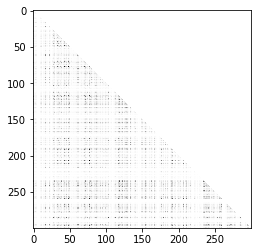

In [13]:
plt.imshow(pairs, cmap="Greys");

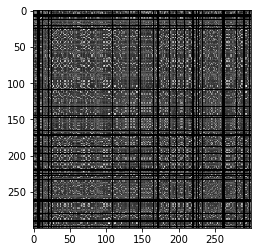

In [14]:
nDrafts = draftCount
prob = pairs*1.0 # Make a copy, and also make symmetric

for i in range(nCards):
    for j in range(i+1):
        if freq[i]>0 and freq[j]>0:
            prob[i,j] = prob[i,j]/float(freq[i])/float(freq[j])*nDrafts
            prob[j,i] = prob[i,j]
        
dist = (1-0.99*prob/prob.max())
plt.imshow(dist, cmap="Greys");

In [15]:
# Debugging: a list of cards that weren't drafted, but are in the db
for i in range(nCards):
    if freq[i]==0:
        print(cardlist[i])
        del cardpicks[cardlist[i]] # Remove undrafted cards from the dictionary

aggressive_mammoth
air_elemental
ajani's_influence
ajani_wise_counselor
arisen_gorgon
befuddle
court_cleric
grasping_scoundrel
gravewaker
kargan_dragonrider
liliana's_spoils
liliana_the_necromancer
llanowar_elves
mist-cloaked_herald
nexus_of_fate
nicol_bolas_the_arisen
pendulum_of_patterns
radiating_lightning
riddlemaster_sphinx
sarkhan's_dragonfire
sarkhan's_whelp
sarkhan_dragonsoul
serra's_guardian
shivan_dragon
silverbeak_griffin
skalla_wolf
sun_sentinel
tattered_mummy
tezzeret's_gatebreaker
tezzeret's_strider
tezzeret_cruel_machinist
ursine_champion
vivien_of_the_arkbow
vivien's_jaguar
waterknot


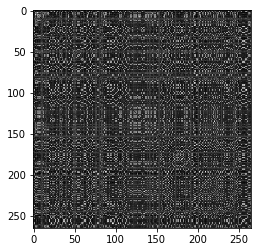

In [16]:
# Remove missing cards from other arrays
# (I make copies of both arrays for some reason, just in case)

dist2 = dist.copy()
dist2 = dist2[freq>0,:]
dist2 = dist2[:,freq>0] # For some reason if I try to subset both rows and columns together, it outputs something stupid
plt.imshow(dist2, cmap="Greys");

freq2 = freq[freq>0]

In [17]:
fit = skm.locally_linear_embedding(dist2, n_components=2, n_neighbors=len(freq2)-1)
fit = fit[0] # For some reason it returns a tuple

#embedding = MDS(n_components=2, dissimilarity='precomputed', max_iter=1000, eps=0.0001)
#fit = embedding.fit_transform(dist2)

In [18]:
df = pd.DataFrame({
        'avg'   : [np.mean(cardpicks[card]) for card in cardpicks],
        'var'   : [np.var(cardpicks[card]) for card in cardpicks],
        'count' : [len(cardpicks[card]) for card in cardpicks],
        'color' : [getCardColor(thisSet[card]) for card in cardpicks],
        'rarity': [thisSet[card]['rarity'] for card in cardpicks],
        'legendary' : [1 if isLegendary(thisSet[card]) else 0 for card in cardpicks],
        'x' : fit[:,0],
        'y' : fit[:,1],
        'freq': freq2[:]
    }, list(cardpicks.keys()))

# Now some torturous attempt to use proper color names, while retaining their sequence
colorName = {0:"C", 1:"Multi", 2:"W", 3:"U", 4:"B", 5:"R", 6:"G"}
df['color'] = df.color.map(colorName)
from pandas.api.types import CategoricalDtype
ctype = CategoricalDtype(categories=["C","Multi","W","U","B","R","G"],ordered=True)
df['color'] = df['color'].astype(ctype)

df.head()

,avg,var,count,color,rarity,legendary,x,y,freq
abnormal_endurance,8.643319,8.053730,8809,B,common,0,-0.040512,-0.077600,26607
act_of_treason,9.011468,9.447516,12731,R,common,0,0.049514,-0.071354,36957
aegis_of_the_heavens,10.359304,8.531075,2413,W,uncommon,0,-0.037736,-0.029355,7090
aerial_engineer,5.156216,10.161963,4577,Multi,uncommon,0,-0.093913,0.071021,14515
aether_tunnel,7.301788,9.048126,3635,U,uncommon,0,-0.045936,0.091391,10600


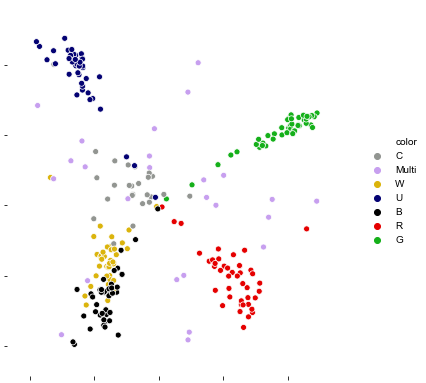

In [19]:
#%matplotlib inline

myPal = sns.xkcd_palette(["grey","lavender","gold","deep blue","black","red","green"])
s = sns.relplot(data=df,x="x",y="y",hue="color",palette=myPal)
s.fig.set_size_inches(7,6)
sns.set_style("white")
s.despine(left=True,bottom=True)
s.set(xticklabels=[],yticklabels=[],xlabel='',ylabel='');

In [20]:
# Save the data.
# Note, it saves to gitHub-visible folder, not to hidden 'data' folder:

df.to_csv('bots/bots_data/basic_data_'+setName+'.csv', index_label="name")
np.savetxt('bots/bots_data/distances_'+setName+'.csv', dist2, delimiter=",")

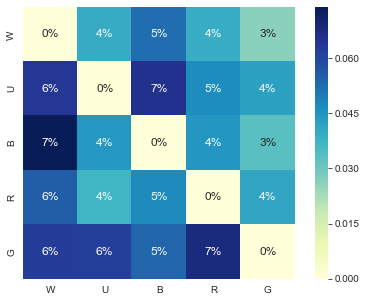

In [21]:
ax = sns.heatmap(guilds/np.sum(guilds), annot=True, fmt="2.0%", cmap="YlGnBu", annot_kws={"size": 12})
ax.set_aspect('equal')
ax.figure.set_size_inches(7,5)
ax.set_xticklabels(["W","U","B","R","G"]); # suppress output, or it returns something
ax.set_yticklabels(["W","U","B","R","G"]); 

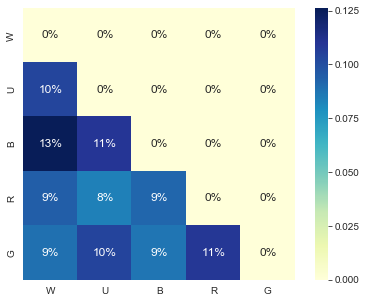

In [22]:
# Symmetric version for symmetric people
guilds_sim = guilds + guilds.transpose()
guilds_sim = np.triu(guilds_sim).transpose()

ax = sns.heatmap(guilds_sim/np.sum(guilds_sim), annot=True, fmt="2.0%", cmap="YlGnBu", annot_kws={"size": 12})
ax.set_aspect('equal')
ax.figure.set_size_inches(7,5)
ax.set_xticklabels(["W","U","B","R","G"]); # suppress output, or it returns something
ax.set_yticklabels(["W","U","B","R","G"]); 

In [23]:
# Top picks:
df.sort_values(by=['avg'], ascending=True).head(12)

,avg,var,count,color,rarity,legendary,x,y,freq
lathliss_dragon_queen,1.0,0.0,1978,R,rare,1,0.066588,-0.031927,5471
bone_dragon,1.0,0.0,879,B,mythic,0,-0.031940,-0.044673,2583
sigiled_sword_of_valeron,1.0,0.0,1646,C,rare,0,-0.007276,0.002225,4645
chromium_the_mutable,1.0,0.0,919,Multi,mythic,1,-0.081523,0.018877,3051
resplendent_angel,1.0,0.0,1012,W,mythic,0,-0.037384,-0.039124,2904
lena_selfless_champion,1.0,0.0,1407,W,rare,1,-0.035666,-0.042024,4074
hungering_hydra,1.0,0.0,1572,G,rare,0,0.095377,0.055207,4624
palladia-mors_the_ruiner,1.0,0.0,818,Multi,mythic,1,0.085195,-0.008445,3033
vivien_reid,1.0,0.0,929,G,mythic,1,0.077446,0.046978,2824
leonin_warleader,1.0,0.0,1915,W,rare,0,-0.034798,-0.040890,5115


In [24]:
# Top controversial cards (without correction for 'intrinsic controversy')
df.sort_values(by=['var'], ascending=False).head(12)

,avg,var,count,color,rarity,legendary,x,y,freq
scapeshift,9.965859,16.921742,1816,G,mythic,0,0.025800,0.014564,6174
satyr_enchanter,8.275028,16.397006,5374,Multi,uncommon,0,0.050340,0.021353,13896
crucible_of_worlds,8.439252,16.055388,1498,C,mythic,0,-0.005871,0.005970,4829
gigantosaurus,6.311039,15.203851,4022,G,rare,0,0.089669,0.050851,11115
enigma_drake,6.318967,14.681937,4803,Multi,uncommon,0,-0.007218,0.035068,15483
omniscience,10.871475,14.376648,1844,U,mythic,0,-0.018799,0.028220,6299
brawl-bash_ogre,5.568084,12.865051,4399,Multi,uncommon,0,0.022693,-0.095697,14491
desecrated_tomb,7.460977,12.773641,1371,C,rare,0,-0.034879,-0.027329,4827
ajani's_welcome,9.753623,11.925139,6003,W,uncommon,0,-0.040324,-0.043488,18185
doublecast,8.499337,11.912096,2261,R,uncommon,0,0.041726,-0.038803,7447
